In [69]:
import numpy
from etrade.spot.trader import Station
from etrade.spot.market.recycle import BasicRecycle, PointwiseRecycle
from etrade.spot.forecast.market import DistributiveSeries, DistributiveMarket
from etrade.spot.forecast.plan_a.constructor import *
from etrade.spot.forecast.plan_a.transformer import MarketSampleTransformer, MarketSampleDataset
from etrade.spot.forecast.yieldindex import zero_quantile
from etrade.spot.forecast import yieldindex
from  data_utils.stochastic_utils.vdistributions.abstract import AbstractDistribution
from  data_utils.stochastic_utils.vdistributions.parameter.continuous.basic import NormalDistribution, SkewNormalDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.kernel2 import KernelMixDistribution
from data_utils.stochastic_utils.vdistributions.tools.divergence import kl_divergence_continuous, crps, quantile_RMSE

from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.mfk.skewnd2 import dof_snd_fitter

from scipy.optimize import differential_evolution

from matplotlib import pyplot
import json

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [70]:

with open(r"..\forecast\plan_a\data\market_simulator_5.json", "r") as f:
    train_data = json.loads(f.read())
    
with open(r"..\forecast\plan_a\data\market_simulator_6.json", "r") as f:
    test_data = json.loads(f.read())

In [71]:
train_data =numpy.asarray(train_data["data"])
test_data =numpy.asarray(test_data["data"])

In [72]:
# print(train_data[:10].tolist())
print(len(train_data[0]))

170


In [73]:
# market_len = 1
# # l = 3 * market_len + market_len
# l = market_len * 126 + market_len * (5-0) * 3 + 9
l = len(train_data[0]) - 1
def zscore_p(x):
    x = numpy.asarray(x)
    m = numpy.mean(x, axis=0)
    s = numpy.std(x, ddof=1, axis=0)
    return m,s

def zscore(x, m, s):
    x = numpy.asarray(x)
    m = numpy.asarray(m)
    s = numpy.asarray(s)
    # return numpy.column_stack((
    #         (x[:,:l]-m[:l]) / s[:l], x[:,l]
    # ))
    return (x-m) / s

def minmax_p(x):
    x = numpy.asarray(x)
    mmax = numpy.max(x, axis=0)
    mmin = numpy.min(x, axis=0)
    return mmin, mmax

def minmax(x, mmin, mmax):
    x = numpy.asarray(x)
    mmin = numpy.asarray(mmin)
    mmax = numpy.asarray(mmax)
    return (x-mmin) / (mmax-mmin)
    # return numpy.column_stack((
    #         (x[:,:l]-mmin[:l]) / (mmax[:l]-mmin[:l]), x[:,l]
    # ))
    
print(l)
    

169


In [74]:
m,s= zscore_p(train_data)
zscored_t = zscore(train_data, m, s)
zscored_x = zscore(test_data, m, s)

mmin,mmax = minmax_p(train_data)
minmaxed_t = minmax(train_data, mmin, mmax)
minmaxed_x = minmax(test_data, mmin, mmax)

print(zscored_t.shape)
# print(zscored_t[:10].tolist())

(3000, 170)


In [90]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
# p = MLPRegressor(
#     hidden_layer_sizes=[50] * 4,
#     activation="relu",
#     solver="lbfgs",
#     # alpha=1e-3,
#     # learning_rate_init=1e-3
# )
p = RandomForestRegressor(
    # alpha=0.999
)
# p = SVR(
#     # alpha=1
# )
p.fit(
    zscored_t[:,:l],
    zscored_t[:,l]
)

RandomForestRegressor()

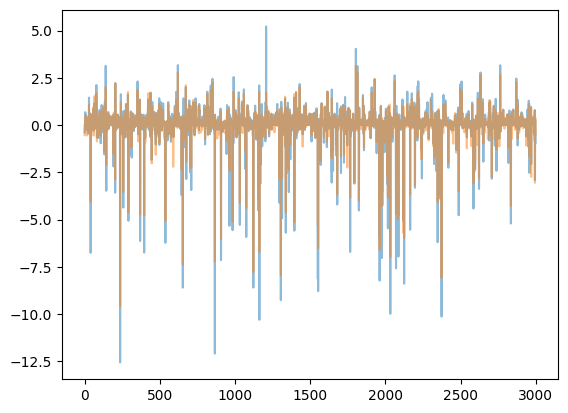

In [91]:

pyplot.plot(zscored_t[:,l], alpha=0.5)
pyplot.plot(p.predict(zscored_t[:,:l]), alpha=0.5)

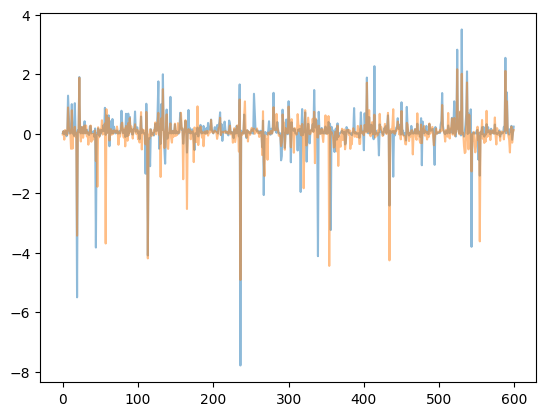

In [92]:

pyplot.plot(zscored_x[:,l], alpha=0.5)
pyplot.plot(p.predict(zscored_x[:,:l]), alpha=0.5)

In [93]:
p.score(zscored_x[:,:l], zscored_x[:,l])

0.4033852159246304

In [94]:
p.score(zscored_t[:,:l], zscored_t[:,l])

0.9037089789856025

In [95]:
numpy.corrcoef(p.predict(zscored_x[:,:l]), zscored_x[:,l])

array([[1.        , 0.66958694],
       [0.66958694, 1.        ]])

In [88]:
model = MarketSampleTransformer(l, 256, 4, 2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()

C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [89]:
batch_size = 600
epoch_size = 200

zscored_t_dataset = MarketSampleDataset(zscored_t)
train_loader = DataLoader(zscored_t_dataset, batch_size=batch_size, shuffle=True)

zscored_x_dataset = MarketSampleDataset(zscored_x)
test_loader = DataLoader(zscored_x_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epoch_size):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        # batch_x, batch_y = batch_x, batch_y
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            # batch_x, batch_y = batch_x, batch_y
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            test_loss += loss.item() * batch_x.size(0)
    avg_test_loss = test_loss / len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{epoch_size} | Train Loss: {avg_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

Epoch 1/200 | Train Loss: 5.078064 | Test Loss: 0.520907
Epoch 2/200 | Train Loss: 1.350744 | Test Loss: 1.098279
Epoch 3/200 | Train Loss: 1.181581 | Test Loss: 0.543768
Epoch 4/200 | Train Loss: 1.045275 | Test Loss: 0.448870
Epoch 5/200 | Train Loss: 0.953166 | Test Loss: 0.485050
Epoch 6/200 | Train Loss: 0.905598 | Test Loss: 0.441126
Epoch 7/200 | Train Loss: 0.892969 | Test Loss: 0.440268
Epoch 8/200 | Train Loss: 0.848629 | Test Loss: 0.419384
Epoch 9/200 | Train Loss: 0.818661 | Test Loss: 0.406778
Epoch 10/200 | Train Loss: 0.772344 | Test Loss: 0.441905
Epoch 11/200 | Train Loss: 0.699842 | Test Loss: 0.386992
Epoch 12/200 | Train Loss: 0.627506 | Test Loss: 0.352696
Epoch 13/200 | Train Loss: 0.531617 | Test Loss: 0.370474
Epoch 14/200 | Train Loss: 0.421262 | Test Loss: 0.371151
Epoch 15/200 | Train Loss: 0.336517 | Test Loss: 0.263786
Epoch 16/200 | Train Loss: 0.314371 | Test Loss: 0.386654
Epoch 17/200 | Train Loss: 0.247364 | Test Loss: 0.277481
Epoch 18/200 | Train Lo

In [83]:
model.eval()
all_preds = []
all_targets = []
# 拿一批数据来预测
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        all_preds.append(preds)    # 收集预测结果
        all_targets.append(batch_y)  # 收集真实标签
        
all_preds = torch.cat(all_preds, dim=0).numpy()     # (400,)
all_targets = torch.cat(all_targets, dim=0).numpy() # (400,)

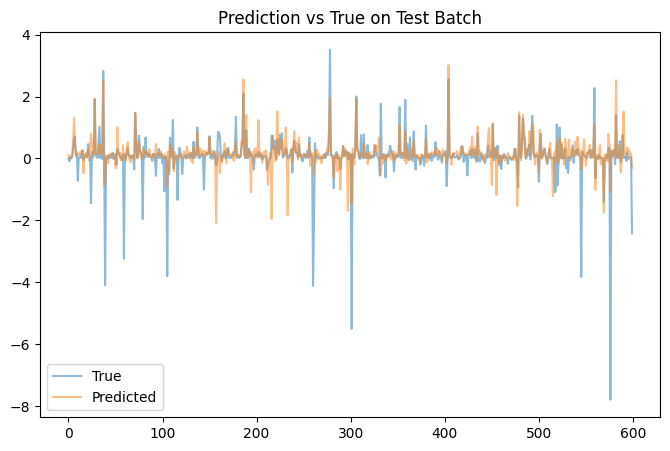

In [84]:
pyplot.figure(figsize=(8,5))
pyplot.plot(all_targets, label="True", alpha=0.5)
pyplot.plot(all_preds, label="Predicted", alpha=0.5)

pyplot.legend()
pyplot.title("Prediction vs True on Test Batch")
pyplot.show()

In [85]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_absolute_error(all_targets, all_preds)
print(f"Test MSE on 600 samples: {mse:.6f}")

Test MSE on 600 samples: 0.265362


In [86]:
from sklearn.metrics import r2_score
r2 = r2_score(all_targets, all_preds)
print(f"Test R^2 on 600 samples: {r2:.6f}")

Test R^2 on 600 samples: 0.268185


In [87]:
print(zscored_t[:10].tolist())

[[-2.07274517722613, -0.22460563162144007, 0.8227693157251134, -0.7780738189185401, -0.2472148755419713, -0.06625196125643092, 0.09499045447198717, 0.21191183333118646, 0.3009916226665105, 0.3592303365562182, 0.3823029470368802, 0.356834671230951, 0.22474421755088134, -0.11563742412394876, -0.19194952704427862, -0.06992921421816661, -0.24103247818715143, -0.3574965420339851, -0.3115447961936192, -0.17169000932288173, -0.060801482612036384, -0.047063412241368265, -0.09714586005535569, 0.008117517195045686, 0.07576606165593656, 0.2371065042260053, 0.7523799915991048, 1.151211114412506, 1.5029227614277325, 1.8044584507598975, 2.0193505937422107, 2.1064293686846822, 1.9607310743399327, 0.8486931664392433, 0.36592757966121087, 0.23104136454600707, 0.3141482814344033, 0.2564621261797466, 0.07959324601958631, -0.3620334019662484, -0.5004108547203864, -0.37025326763038197, -0.35026170258677525, 0.12522238324425877, 0.5046845097374866, 0.8983880937071801, -0.17291516348652214, 2.818242348895538